# CNN Regression based on Holography Paper - Distance and Logmass Output

The neural network architecture in this paper is based on the regression CNN in Convolutional neural network-based regression for depth prediction in digital holography (arXiv:1802.00664). 

In [1]:
import os.path
import io
import itertools

import numpy as np
from time import time

from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
import keras.layers as layers
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
import matplotlib

from astropy.io import fits
from astropy.table import Table
from utils import *

from decimal import Decimal
import math

directory = '/opt/data/NeuralNetwork/dssi_dwarfs/'
info_file = os.path.join(directory, 'stamps3.ecsv')

Using TensorFlow backend.


## User Methods

In [2]:
def get_input(filename):
    """
    Loader function for teh data given a filename
    """
    
    f = fits.open(os.path.join(directory, filename))
    img = f[0].data.transpose((1, 2, 0)) # move channels to last.
    return img


def get_output(dwarf_table_row, columns):    
    """
    Loader function for the y_true parameters.
    """
    
    return np.array([scale_column(column_scaling, c, dwarf_table_row[c]) for c in columns])

def preprocess_input(image):
    """
    Any preprocessing we want done... none at this point.
    """
    
#     --- Rescale Image
#     --- Rotate Image
#     --- Resize Image
#     --- Flip Image
#     --- PCA etc.
    
    return(image)


## Load the Information File

In [3]:
dwarfs_table = Table.read(info_file, format='ascii.ecsv')
dwarfs_table

<Table length=11842>
                      filename                       logmass ... noise_z noise_y
                       str52                         float64 ... float64 float64
---------------------------------------------------- ------- ... ------- -------
stamps3/d14.09_m6.19_re0.40_feh-1.8_age13.3_HSC.fits  6.1866 ...  0.0208  0.0203
stamps3/d11.87_m8.38_re0.81_feh-1.0_age10.1_HSC.fits  8.3765 ...  0.0204  0.0203
stamps3/d11.07_m6.84_re0.49_feh-1.5_age14.7_HSC.fits  6.8434 ...  0.0201  0.0208
  stamps3/d1.74_m8.75_re0.91_feh-0.8_age7.9_HSC.fits  8.7495 ...  0.0200  0.0203
stamps3/d12.56_m6.25_re0.41_feh-1.5_age10.1_HSC.fits  6.2513 ...  0.0209  0.0209
 stamps3/d8.91_m8.43_re0.82_feh-1.0_age10.9_HSC.fits  8.4296 ...  0.0207  0.0207
 stamps3/d3.30_m6.60_re0.46_feh-1.5_age11.3_HSC.fits  6.6019 ...  0.0201  0.0205
 stamps3/d3.86_m5.14_re0.29_feh-2.0_age11.6_HSC.fits  5.1433 ...  0.0208  0.0207
  stamps3/d2.63_m7.32_re0.58_feh-1.2_age9.6_HSC.fits  7.3225 ...  0.0207  0.0201
 stamps3/d5.54_m7.09_re0.54_feh-1.2_age13.5_HSC.fits  7.0914 ...  0.0204  0.0203
                                                 ...     ... ...     ...     ...
stamps3/d11.35_m5.44_re0.32_feh-1.8_age13.6_HSC.fits  5.4360 ...  0.0209  0.0203
 stamps3/d11.63_m6.92_re0.51_feh-1.5_age8.9_HSC.fits  6.9219 ...  0.0206  0.0200
 stamps3/d2.16_m5.37_re0.31_feh-2.0_age12.5_HSC.fits  5.3670 ...  0.0208  0.0206
  stamps3/d8.38_m6.15_re0.40_feh-1.8_age9.7_HSC.fits  6.1500 ...  0.0203  0.0203
  stamps3/d5.70_m6.68_re0.47_feh-1.5_age8.7_HSC.fits  6.6838 ...  0.0205  0.0204
 stamps3/d3.11_m5.24_re0.30_feh-2.0_age10.2_HSC.fits  5.2359 ...  0.0207  0.0204
 stamps3/d6.17_m6.42_re0.43_feh-1.5_age13.7_HSC.fits  6.4222 ...  0.0203  0.0210
 stamps3/d6.78_m7.99_re0.71_feh-1.0_age11.6_HSC.fits  7.9878 ...  0.0200  0.0206
stamps3/d12.79_m7.28_re0.57_feh-1.2_age13.8_HSC.fits  7.2829 ...  0.0207  0.0201
 stamps3/d3.86_m7.51_re0.61_feh-1.2_age10.1_HSC.fits  7.5052 ...  0.0207  0.0201

## Setup the Columns of Interest

In [4]:
# Calculate the scale factors for each attribute
columns = ['distance', 'logmass', 'rekpc', 'FeH', 'age']

column_scaling = {}
for column in columns:
  column_scaling[column] = {
      'min': np.percentile(dwarfs_table[column], 0.01), 
      'max': np.percentile(dwarfs_table[column], 99.99)
}

print('Columns Scaling is {}'.format(column_scaling))

Columns Scaling is {'distance': {'min': 1.00175774, 'max': 14.99940544}, 'logmass': {'min': 5.00041841, 'max': 8.999544769999998}, 'rekpc': {'min': 0.2739, 'max': 0.98898159}, 'FeH': {'min': -2.0, 'max': -0.75}, 'age': {'min': 3.77847319, 'max': 14.992500419999999}}


## Load the Data into Test and Train

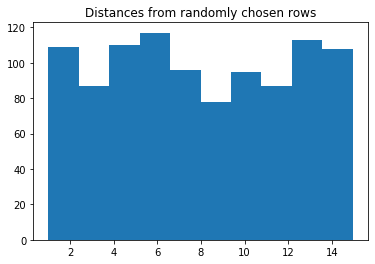

In [5]:
# Get a list of all row indices
indices = range(len(dwarfs_table))

# training indices
#counts, bins = np.histogram(dwarfs_table['distance'], np.arange(1, 15))

# plt.plot(counts)
# plt.title('Histogram of distances')

# Calculate the probability for each point with which we want it chosen.
# plookup = (1 / len(counts)) * (1 / counts)
#probabilities = np.array([plookup[int(x)] for x in np.floor(dwarfs_table['distance'])])
probabilities = np.ones(len(indices),) / len(indices)

probabilities = probabilities / np.sum(probabilities)

# As a test we are going to randomly choose 1000 points to make sure that what comes back is a uniform distribution
# of distances.
plt.figure()
out = np.random.choice(dwarfs_table['distance'], 1000, p=probabilities)
plt.hist(out)
plt.title('Distances from randomly chosen rows')

# Now get the training, validation and test indices
training_test_indices = random_subsets(indices, [8000, 500, 2000], probabilities=probabilities)
training_indices, validation_indices, test_indices = training_test_indices

## Compile the Neural Network

In [8]:
EPOCHS = 20
BATCH_SIZE = 100

model = keras.Sequential()

# 1st Convolutional Layer 
model.add(layers.Conv2D(filters=32, input_shape=(256,256,5), kernel_size=(3,3), padding='valid'))
model.add(layers.Activation('relu'))
# Pooling 
model.add(layers.MaxPooling2D(pool_size=(3,3), padding='valid'))

# 2nd Convolutional Layer
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), padding='valid'))
model.add(layers.Activation('relu'))
# Pooling
model.add(layers.MaxPooling2D(pool_size=(3, 3), padding='valid'))

# 3rd Convolutional Layer
model.add(layers.Conv2D(filters=128, kernel_size=(3,3), padding='valid'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(3, 3), padding='valid'))

# 4th Convolutional Layer
model.add(layers.Conv2D(filters=256, kernel_size=(3,3), padding='valid'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(3,3), padding='valid'))

# Passing it to a dense layer
model.add(layers.Flatten())
# 1st Dense Layer
model.add(layers.Dense(2048, input_shape=(16*16*256,)))
model.add(layers.Activation('relu'))

# Add Dropout to prevent overfitting
model.add(layers.Dropout(0.4))

# 2nd Dense Layer
model.add(layers.Dense(2048))
model.add(layers.Activation('relu'))
# Add Dropout
model.add(layers.Dropout(0.4))

# Output Layer
model.add(layers.Dense(5, activation='linear'))

model.summary()

from keras.optimizers import Adam
adam = Adam(lr=0.0005)

model.compile(loss='mse', optimizer=adam)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 254, 254, 32)      1472      
_________________________________________________________________
activation_7 (Activation)    (None, 254, 254, 32)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 84, 84, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 82, 82, 64)        18496     
_________________________________________________________________
activation_8 (Activation)    (None, 82, 82, 64)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 27, 27, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 25, 25, 128)       73856     
__________

## Train the Neural Network

In [9]:
EPOCHS = 10
BATCH_SIZE = 64

train_generator = image_generator(dwarfs_table, training_indices, columns, get_input, get_output, batch_size=BATCH_SIZE)
validation_generator = image_generator(dwarfs_table, validation_indices, columns, get_input, get_output, batch_size=BATCH_SIZE)
test_generator = image_generator(dwarfs_table, test_indices, columns, get_input, get_output, batch_size=BATCH_SIZE)

steps_per_epoch = len(training_indices)//BATCH_SIZE
validation_steps = len(validation_indices)//BATCH_SIZE

history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=EPOCHS, 
                    validation_data=validation_generator, validation_steps=validation_steps,
                    shuffle=True, callbacks=[])


Epoch 1/10
125/125 [==============================] - 502s 4s/step - loss: 0.4238 - val_loss: 0.0119
Epoch 2/10
125/125 [==============================] - 524s 4s/step - loss: 0.0135 - val_loss: 0.0076
Epoch 3/10
125/125 [==============================] - 525s 4s/step - loss: 0.0102 - val_loss: 0.0065
Epoch 4/10
125/125 [==============================] - 556s 4s/step - loss: 0.0094 - val_loss: 0.0061
Epoch 5/10
125/125 [==============================] - 547s 4s/step - loss: 0.0093 - val_loss: 0.0066
Epoch 6/10
125/125 [==============================] - 539s 4s/step - loss: 0.0085 - val_loss: 0.0065
Epoch 7/10
125/125 [==============================] - 540s 4s/step - loss: 0.0081 - val_loss: 0.0065
Epoch 8/10
125/125 [==============================] - 543s 4s/step - loss: 0.0080 - val_loss: 0.0064
Epoch 9/10
125/125 [==============================] - 519s 4s/step - loss: 0.0072 - val_loss: 0.0054
Epoch 10/10
125/125 [==============================] - 534s 4s/step - loss: 0.0070 - val_lo

## Show Training Output

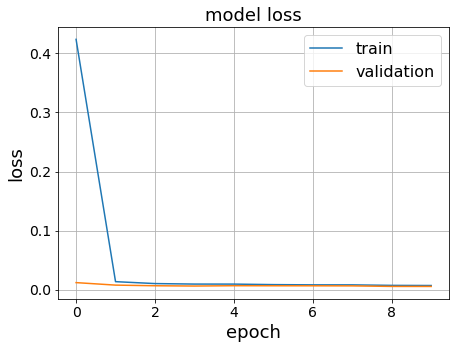

In [10]:
matplotlib.rc('xtick', labelsize=14)
matplotlib.rc('ytick', labelsize=14)                                                                                                                                                                                               

plt.figure(2, figsize=[7, 5])
plt.clf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss', fontsize=18)
plt.ylabel('loss', fontsize=18)
plt.xlabel('epoch', fontsize=18)
plt.legend(['train', 'validation'], fontsize=16)
plt.grid('on')
plt.show()


## Show Results Compared to Truth

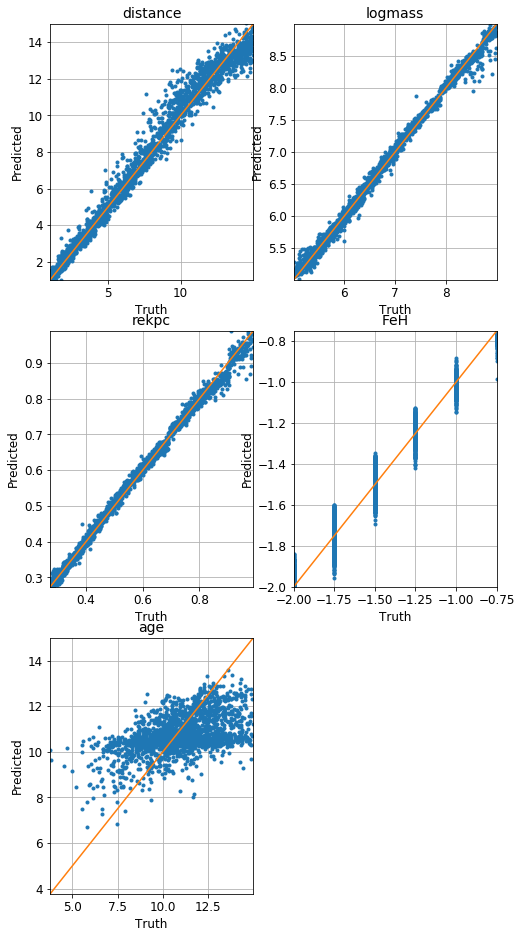

In [22]:
matplotlib.rc('xtick', labelsize=12)
matplotlib.rc('ytick', labelsize=12)                                                                                                                                                                                               


calculated = np.zeros((len(test_indices), len(columns)))
truth = np.zeros((len(test_indices), len(columns)))

for ii, test_indice in enumerate(test_indices):
    row = dwarfs_table[test_indice]
    
    data = get_input(row['filename'])

    values = model.predict(data[None,:])[0]

    for jj, c in enumerate(columns):
        cmin, cmax = column_scaling[c]['min'], column_scaling[c]['max']
        values[jj] = values[jj] * (cmax - cmin) + cmin

    calculated[ii] = values
    truth[ii] = [row[c] for c in columns]


plt.figure(3, figsize=[8, 16])
plt.clf()

cs = int(np.sqrt(len(columns)))
rs = int(math.ceil(len(columns) / cs))

for ci, c in enumerate(columns):
    plt.subplot(rs, cs, ci+1)
    plt.plot(truth[:, ci], calculated[:, ci], '.')
    plt.title(c, fontsize=14)
    cmin, cmax = column_scaling[c]['min'], column_scaling[c]['max']
    plt.xlim((cmin, cmax))
    plt.ylim((cmin, cmax))
    plt.grid('on')
    plt.xlabel('Truth', fontsize=12)
    plt.ylabel('Predicted', fontsize=12)
    plt.plot([cmin, cmax], [cmin, cmax])


In [16]:
model.save('papernet-stamps3-dist-logmass-rekpc-feh-age.h5')